In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio, display, Image
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split

#### Rename files in format: species_name_##.mp3

In [2]:
BASE_DIR = Path("sa_bird_audio")
species_dirs = [d for d in BASE_DIR.iterdir() if d.is_dir()]

for species_dir in species_dirs:
    species_name = species_dir.name.replace(" ", "_")
    mp3_files = sorted(species_dir.glob("*.mp3"))
    
    for idx, mp3_file in enumerate(mp3_files, start=1):
        new_filename = f"{species_name}_{idx:02d}.mp3"
        new_filepath = species_dir / new_filename
        mp3_file.rename(new_filepath)

#### Load .mp3 convert to spectrogram

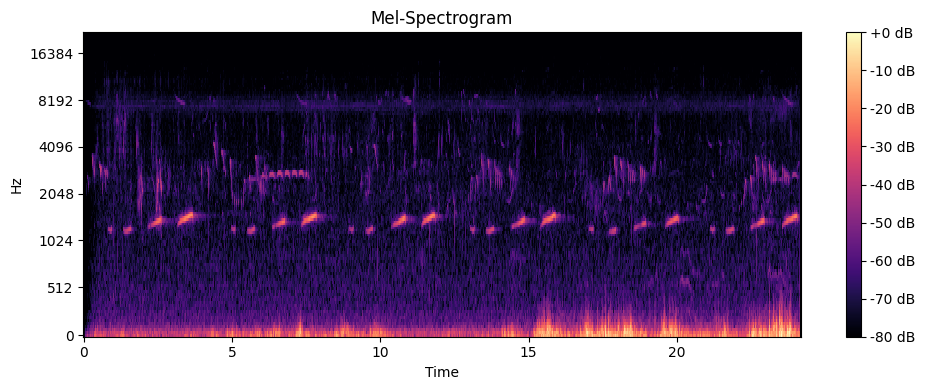

44100


In [3]:
# Load the MP3 file directly
audio_path = 'sa_bird_audio/Black Cuckoo/Black_Cuckoo_02.mp3'
y, sr = librosa.load(audio_path, sr=None)  # sr=None keeps the original sampling rate

# Compute the Mel-spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)  # You can adjust `n_mels`
S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to decibels

# Display the Mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

print(sr)

#### Listen to the auido

In [74]:
# Play the audio in the notebook
display(Audio(data=y, rate=sr))

#### Convert to .npy numpy arrays

In [75]:
# Set paths
input_root = "sa_bird_audio"
output_root = "npy_spectrograms"

# Supported audio formats
audio_formats = (".mp3")

#keep track of metadata
metadata = []

# Process each species folder
for species_folder in os.listdir(input_root):
    species_path = os.path.join(input_root, species_folder)
    
    # Skip if not a directory
    if not os.path.isdir(species_path):
        continue
    
    # Create corresponding output directory
    output_species_dir = os.path.join(output_root, species_folder)
    os.makedirs(output_species_dir, exist_ok=True)

    # Process each audio file in the species folder
    for audio_file in os.listdir(species_path):
        if audio_file.lower().endswith(audio_formats):
            # Load audio
            audio_path = os.path.join(species_path, audio_file)
            y, sr = librosa.load(audio_path, sr=None)
            
            # Generate Mel-Spectrogram
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_dB = librosa.power_to_db(S, ref=np.max)

            #get duration
            duration = librosa.get_duration(y=y, sr=sr)
            
            # Save as .npy file (instead of plotting and saving PNG)
            output_file = os.path.splitext(audio_file)[0] + ".npy"
            output_path = os.path.join(output_species_dir, output_file)
            np.save(output_path, S_dB)  # Save the NumPy array directly

            #save metadata
            metadata.append({
                "species": species_folder,
                "npy_filename": output_file,
                "original_mp3": audio_path,
                "duration": duration
            })


print(f"Finished! Spectrograms saved in {output_root}")

df = pd.DataFrame(metadata)
df.to_csv("metadata.csv", index=False)

Finished! Spectrograms saved in npy_spectrograms


#### Inspect a .npy file

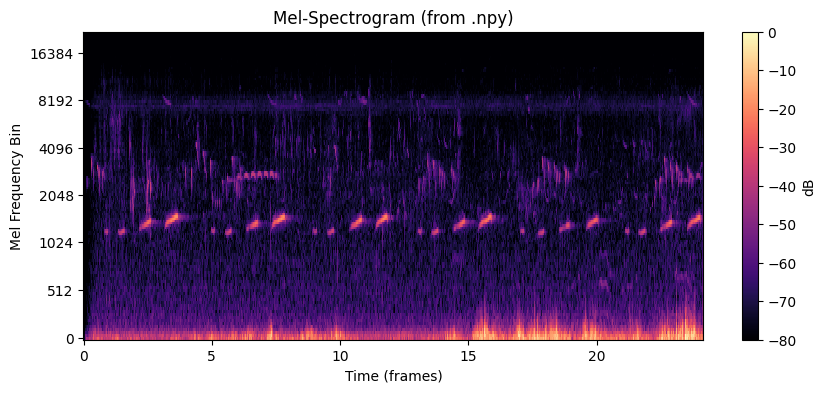

In [77]:
# Path to your .npy file
npy_path = "npy_spectrograms/Black Cuckoo/Black_Cuckoo_02.npy"

# Load the spectrogram
S_dB = np.load(npy_path)  # Shape: (n_mels, time_steps)


# Plot the spectrogram
plt.figure(figsize=(10, 4))
#plt.imshow(S_dB, aspect='auto', origin='lower', cmap='viridis')
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(label='dB')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Frequency Bin')
plt.title('Mel-Spectrogram (from .npy)')
plt.show()

#### Flatten npy_spectrogram directory structure in directory flattened_npy_spectrograms

In [83]:
# Source and destination directories
SRC_DIR = Path("npy_spectrograms")
DEST_DIR = Path("flattened_npy_spectrograms")
DEST_DIR.mkdir(exist_ok=True)

# Copy each .npy file from subdirectories into the new flat directory
for subdir in SRC_DIR.iterdir():
    if subdir.is_dir():
        for npy_file in subdir.glob("*.npy"):
            dest_path = DEST_DIR / npy_file.name
            shutil.copy2(npy_file, dest_path)


#### Inspect metadata.csv

In [87]:
metadata_df = pd.read_csv('metadata.csv')
metadata_df.head()

,species,npy_filename,original_mp3,duration
0,Chestnut-vented Warbler,Chestnut-vented_Warbler_17.npy,sa_bird_audio/Chestnut-vented Warbler/Chestnut...,29.00
1,Chestnut-vented Warbler,Chestnut-vented_Warbler_02.npy,sa_bird_audio/Chestnut-vented Warbler/Chestnut...,29.00
2,Chestnut-vented Warbler,Chestnut-vented_Warbler_73.npy,sa_bird_audio/Chestnut-vented Warbler/Chestnut...,29.00
3,Chestnut-vented Warbler,Chestnut-vented_Warbler_24.npy,sa_bird_audio/Chestnut-vented Warbler/Chestnut...,17.92
4,Chestnut-vented Warbler,Chestnut-vented_Warbler_05.npy,sa_bird_audio/Chestnut-vented Warbler/Chestnut...,29.00


#### Sort alphanumerically by npy_filename

In [88]:
metadata_df.sort_values(by='npy_filename', inplace=True, ignore_index=True)
metadata_df.head()

,species,npy_filename,original_mp3,duration
0,African Paradise Flycatcher,African_Paradise_Flycatcher_01.npy,sa_bird_audio/African Paradise Flycatcher/Afri...,17.880
1,African Paradise Flycatcher,African_Paradise_Flycatcher_02.npy,sa_bird_audio/African Paradise Flycatcher/Afri...,29.000
2,African Paradise Flycatcher,African_Paradise_Flycatcher_03.npy,sa_bird_audio/African Paradise Flycatcher/Afri...,19.489
3,African Paradise Flycatcher,African_Paradise_Flycatcher_04.npy,sa_bird_audio/African Paradise Flycatcher/Afri...,29.000
4,African Paradise Flycatcher,African_Paradise_Flycatcher_05.npy,sa_bird_audio/African Paradise Flycatcher/Afri...,29.000


In [89]:
metadata_df.to_csv("metadata.csv", index=False)

#### Make train, val, test folds

In [94]:
# Split into train/val/test (e.g., 60/20/20), strtified along species label since data is limited
temp_train_df, test_df = train_test_split(metadata_df, test_size=0.2, random_state=1992, stratify=metadata_df['species'])
train_df, val_df = train_test_split(temp_train_df, test_size=0.2, random_state=1992, stratify=temp_train_df['species'])

# Add split column
metadata_df["split"] = None
metadata_df.loc[train_df.index, "split"] = "train"
metadata_df.loc[val_df.index, "split"] = "val"
metadata_df.loc[test_df.index, "split"] = "test"

In [97]:
metadata_df.head()

,species,npy_filename,original_mp3,duration,split
0,African Paradise Flycatcher,African_Paradise_Flycatcher_01.npy,sa_bird_audio/African Paradise Flycatcher/Afri...,17.880,val
1,African Paradise Flycatcher,African_Paradise_Flycatcher_02.npy,sa_bird_audio/African Paradise Flycatcher/Afri...,29.000,val
2,African Paradise Flycatcher,African_Paradise_Flycatcher_03.npy,sa_bird_audio/African Paradise Flycatcher/Afri...,19.489,test
3,African Paradise Flycatcher,African_Paradise_Flycatcher_04.npy,sa_bird_audio/African Paradise Flycatcher/Afri...,29.000,train
4,African Paradise Flycatcher,African_Paradise_Flycatcher_05.npy,sa_bird_audio/African Paradise Flycatcher/Afri...,29.000,test


#### Check Counts for Train, Val, Test Folds

In [98]:
total_count = metadata_df.shape[0]
train_count = metadata_df[metadata_df['split'] == 'train'].shape[0]
val_count = metadata_df[metadata_df['split'] == 'val'].shape[0]
test_count = metadata_df[metadata_df['split'] == 'test'].shape[0]

total_percent = round((total_count/total_count)*100)
train_percent = round((train_count/total_count)*100)
val_percent = round((val_count/total_count)*100)
test_percent = round((test_count/total_count)*100)

print(f'total: {total_count}({total_percent}%)')
print(f'train: {train_count}({train_percent}%)')
print(f'val: {val_count}({val_percent}%)')
print(f'test: {test_count}({test_percent}%)')

total: 1857(100%)
train: 1188(64%)
val: 297(16%)
test: 372(20%)


#### Visualize Imbalance in Training Data
Will add augmented data later

<Axes: xlabel='species'>

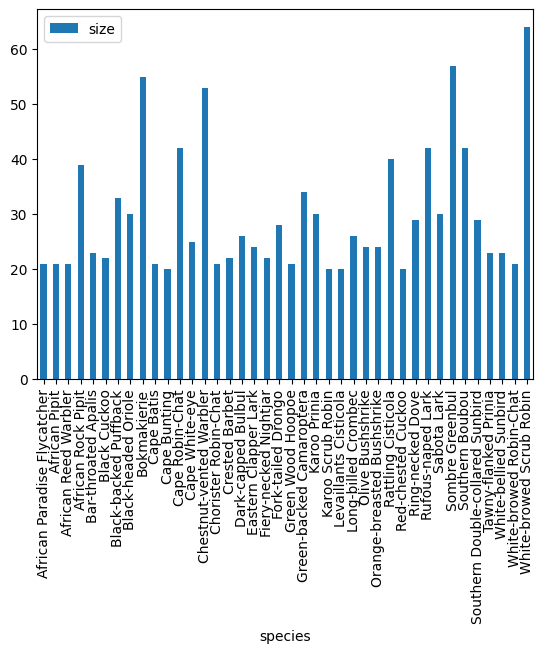

In [99]:
metadata_df[metadata_df['split']=='train'].groupby(by='species', as_index=False).size().plot.bar('species','size')

#### Visualize duration of audio clips

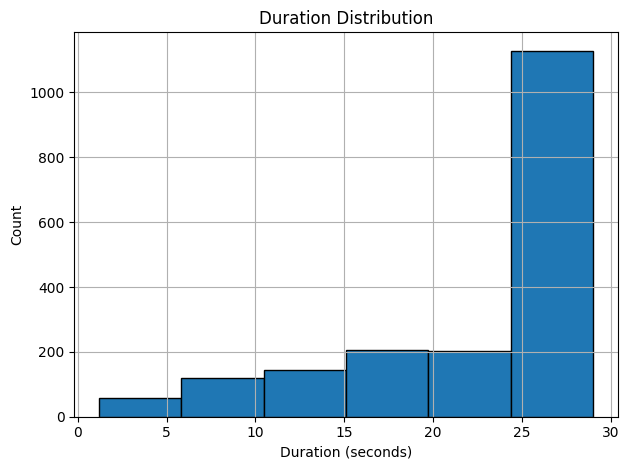

In [105]:
metadata_df['duration'].hist(bins=6, edgecolor='black')

plt.title("Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Save final metadata.csv

In [ ]:
metadata_df.to_csv("metadata.csv", index=False)